# Full code pipeline for running an ensemble on the provided ECG data with PySpark and Torch
Note: You need to run the Docker Image to get the appropraite dependencies correct to run this notebook yourself. See our [docker.md](docker.md) for instructions.

## Start spark session
This will be used by `TorchDistributor` to allocate the necessary memory space for each process.

In [1]:
from pyspark.ml.torch.distributor import TorchDistributor 
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

## Install torch
This is the only package we need that isn't part of the Docker Image that you need to use to run this code.

In [2]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 MB 5.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 6.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
Note: you may need to restart the kernel to use updated packages.


## Import libraries and create directory for models
Most important package is torch, some of the packages are only used for visualizations or to manage the data.

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, DataLoader
from scipy import stats
import time as time
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import warnings
from datetime import datetime

# We create a new directory called 'models_and_results/CURRENT_DATE_TIME' where we store 
# the models and the corresponding anomaly scores
warnings.filterwarnings("ignore", category=FutureWarning)
current_time = datetime.now().strftime('%d%m_%H%M%S')
base_directory = './models_and_results/'
new_directory = os.path.join(base_directory, current_time)
os.makedirs(new_directory, exist_ok=True)

## Import the dataset

The dataset has been taken from [this link](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). It comprises 4998 stime series, each evaluated in 140 time points. An additional column is added for labels (1: normal, 0: anomalous) There are 2079 normal signals in total (41.6% of the total dataset).
* `input_dim`: number of time points for each time series
* `encoding_dim`: number of encoded features in the latent space

The following code imports and prepares the dataset for training and testing

In [4]:
# For reproducibility we set a seed. 
random_SEED = 42
np.random.seed(random_SEED) 

# Load data
df_raw_data = pd.read_csv('ECG5000/ecg.csv', header=None) 
# Set name for columns
df_raw_data.columns = [f't{i+1}' for i in range(df_raw_data.shape[1] - 1)] + ['label'] 
# Transform to tensor (last column is for label)
torch_data_normal = torch.tensor(df_raw_data[df_raw_data['label'] == True].values[:,:-1], dtype=torch.float32) 
# Transform to tensor (last column is for label)
torch_data_anomalous = torch.tensor(df_raw_data[df_raw_data['label'] == False].values[:,:-1], dtype=torch.float32) 

# We hold out some normal data that later is used for testing, 
# the rest of the normal data we store in torch_data_normal
hold_out_idx = torch.tensor(random.sample(range(torch_data_normal.shape[0]), 500)) 
all_indices = torch.arange(torch_data_normal.shape[0]) 
remaining_indices = all_indices[~torch.isin(all_indices, hold_out_idx)]
hold_out_normal = torch_data_normal[hold_out_idx,:]
torch_data_normal = torch_data_normal[remaining_indices,:]

# The following variables are used when defining our Autoencoder model
input_dim = torch_data_normal.shape[1]
encoding_dim = 10

## Print some numbers of the data
print(f'Training data (normal): {torch_data_normal.shape[0]}')
print(f'Anomalous data: {torch_data_anomalous.shape[0]}')
print(f'Hold-out data (normal): {hold_out_normal.shape[0]}')
print(f'Total data: {hold_out_normal.shape[0]+torch_data_anomalous.shape[0]+torch_data_normal.shape[0]}')

Training data (normal): 2419
Anomalous data: 2079
Hold-out data (normal): 500
Total data: 4998


## Split the dataset inot `num_splits` chunks
* `num_splits`:  number of chunks to partition the dataset into
* This will also be the same number of nodes (CPU cores) we distribute to

In [5]:
train_datasets = []

# Chose arbitrary number of splits (less than 10 for data of this size)
num_splits = 9
# Make as even splits as possible
split_sizes = [torch_data_normal.shape[0] // num_splits] * (num_splits - 1) + [torch_data_normal.shape[0] - (torch_data_normal.shape[0] // num_splits) * (num_splits - 1)]
train_datasets = torch.split(torch_data_normal, split_sizes)
for tt_idx, tt in enumerate(train_datasets):
    print(f"{tt.shape[0]} data in chunk number {tt_idx+1}")

268 data in chunk number 1
268 data in chunk number 2
268 data in chunk number 3
268 data in chunk number 4
268 data in chunk number 5
268 data in chunk number 6
268 data in chunk number 7
268 data in chunk number 8
275 data in chunk number 9


## Define the model 
The same model will be used by each process, by this could be generalized 
Here we define an Autoencoder with an encoder three linear layers and ReLU activation between the the layers. The Decoder consists of a mirrored architecture.

In [6]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded
    
# We create a list containing the models
models = [] 
# We initialize a model for each node (CPU core) 
for i in range(num_splits): 
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))

## Define functions to distribute

In [7]:
def train_data_loader(split_index, datasets, batch_size):
    """
    This function creates the dataloader for each node.

    Parameters
    ----------
    split_index : (int)
        The number of the assigned node (0,1,...)
    datasets : (list)
        A list of datasets
    batch_size : (int)
        Size of the minibatch

    Returns
    -------
    A dataloader for the dataset at index split_index
    """

    train_dataset_split_index = TensorDataset(datasets[split_index]) 
    train_dataloader_split_index = DataLoader(train_dataset_split_index, batch_size=batch_size, shuffle=True)
    
    return(train_dataloader_split_index)

def training(models, train_datasets, criterion, num_epochs, batch_size, learning_rate, print_epoch):
    """
    This function is used by the TorchDistributor.

    Parameters
    ----------
    models : [models]
        A list of models to be trained
    train_datasets : (list)
        A list of datasets to be used for training
    criterion : (function)
        Loss function
    num_epochs : (int)
        Number of epochs to be run
    batch_size : (int)
        Size of the minibatch
    learning_rate : (float)
        The learning rate for the optimizer
    print_epoch : (int)
        Determines if we print a loss and how often, set to 0 to omit print
    """
    # Local rank of this process (used to access the corresponding model)
    local_rank = int(os.environ["LOCAL_RANK"]) 

    # Access the model
    model = models[local_rank] 

    # Load the data for this process
    dataloader = train_data_loader(local_rank, train_datasets, batch_size) 
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(1,num_epochs+1): 
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if print_epoch != 0:
            if epoch % print_epoch == 0:
                print(f"Model {local_rank} Epoch [{epoch}/{num_epochs}], Loss: {total_loss/len(dataloader):.6f}")

    ## Save the model weights
    torch.save(model.state_dict(), new_directory + os.sep + "ensemble_" + str(local_rank) + ".pth") # save this model

    return 
    

## Run the training function with TorchDistributor
In [report.md](report.md) you can see the general structure of this function that distributes the training function among the nodes (CPU cores with the current setting). 

In [8]:
# Define a loss function
criterion = nn.MSELoss()

# Hyperparameters
num_epochs = 100
batch_size = 32
learning_rate = 0.01

# Print the loss function's value every 20 epochs
print_epoch = 100

# Benchmark the training
start_time = time.time()

# Run takes arguments: (<function to be run>, <arguments to be passed to function>)
TorchDistributor(num_processes=num_splits, 
                    local_mode=True, 
                    use_gpu=False
                ).run(training,                                # Function to distribute
                models, train_datasets, criterion, num_epochs, # Arguments to pass to function
                batch_size, learning_rate, print_epoch)        # Arguments to pass to function

print('Training took ' , time.time()-start_time ,'s')

Started local training with 9 processes
Finished local training with 9 processes


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
*****************************************
Model 3 Epoch [100/100], Loss: 0.031783
Model 6 Epoch [100/100], Loss: 0.032913
Model 4 Epoch [100/100], Loss: 0.022090
Model 0 Epoch [100/100], Loss: 0.026378
Model 8 Epoch [100/100], Loss: 0.029352
Model 1 Epoch [100/100], Loss: 0.022614
Model 2 Epoch [100/100], Loss: 0.023433
Model 5 Epoch [100/100], Loss: 0.028005
Model 7 Epoch [100/100], Loss: 0.028256
Training took  8.65404224395752 s


# Inference 
Now the training is finished and we move on to the inference stage of this pipeline.

## Load models from directory

In [9]:
# We load the models by creating a new list, initialzing each model and loading the corresponding weights
models = []
for i in range(num_splits):
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))
    models[i].load_state_dict(torch.load(new_directory + os.sep + "ensemble_" + str(i) + ".pth", weights_only=True))
    models[i].eval()

## Prepare test data
We do the inference over an even split of normal and anamlous time series. This results in that the first 500 data series in `new_patients` are normal signals, and the last 500 are anomalies. 

The new data are then partitioned across `num_splits` processes. This split is not required for this particular data (due to the small size) but is used to show that if the test dataset is larger than one machine can handle, our partition makes it feasible by letting each machine loop over one chunk of the partition at a time.

In [10]:
# Concatenate the 500 normal test data with 500 randomly sampled anomalous time series.
new_patients = torch.concat((hold_out_normal, torch_data_anomalous[torch.tensor(random.sample(range(torch_data_anomalous.shape[0]), 500)),:]))

# Create corresponding labels for the 500 normals (ones) and 500 anomalous (zeros)
true_labels = torch.concat((torch.ones(500), torch.zeros(500))).numpy() 


# Partition the data into the list test_datasets
test_datasets = []
num_splits = 9
split_sizes = [new_patients.shape[0] // num_splits] * (num_splits - 1) + [new_patients.shape[0] - (new_patients.shape[0] // num_splits) * (num_splits - 1)]
test_datasets = torch.split(new_patients, split_sizes)
for tt_idx, tt in enumerate(test_datasets):
    print(f"{tt.shape[0]} data in chunk number {tt_idx+1}")

111 data in chunk number 1
111 data in chunk number 2
111 data in chunk number 3
111 data in chunk number 4
111 data in chunk number 5
111 data in chunk number 6
111 data in chunk number 7
111 data in chunk number 8
112 data in chunk number 9


## Inference function to be called by TorchDistributor
This function `inference` is a distributed function that computes the ECDF on the current node's training data. In particular, `normal_ecdf`, defined below, is the estimated ECDF, see the [report.md](report.md). The function then proceeds to evaluate the anomaly scores over the whole partitioned data set.

In [11]:
def inference(models, test_datasets, num_splits, criterion):
    """
    Computes anomaly scores for a specific chunk of a new dataset. To do this the function 
    first computes the ECDF on its corresponding training data. The second part consist of 
    letting the test data stay in each node, but letting the nodes loop over the different
    models such that in the end every model has infered the whole test data. This minimizes
    the data transfer as the test data is only once sent to the corresponding machine and we 
    only need to transfer the models. Finally the scores are saved.

    Parameters
    ----------
    models : (list)
       List of trained models
    test_datasets : (list)
        List of chunks of new data
    num_splits : (int)
        Number of models.
    criterion: 
        Metric used to compute reconstruction error.
    """
    # Local rank of this process (used to access the corresponding model)
    local_rank = int(os.environ["LOCAL_RANK"]) 

    ## The first part - Compute reconstruction losses on training data
    # Load model
    model = models[local_rank] 
    # Set to evaluation mode
    model.eval() 
    normal_loss = []
    with torch.no_grad():
        for j in range(train_datasets[local_rank].shape[0]): 
            # Compute reconstruction loss for each data points in the training data
            normal_loss.append(criterion(model(train_datasets[local_rank][j,:]), train_datasets[local_rank][j,:]).numpy())

    # Computed the ECDF 
    normal_ecdf = stats.ecdf(normal_loss)
    
    ## Second part - evaluate the test data on the ECDF
    # Store the anomaly scores (ECDF - values) in a matrix 
    result_all = np.zeros((test_datasets[local_rank].shape[0], num_splits))

    # Load the test data at the current machine, fixed 
    reconstructed_new_patients = model(test_datasets[local_rank])
    with torch.no_grad():
        # We loop over the different models while keep the test data fixed
        for i in range(num_splits): 
            # Load corresponding model
            model = models[i] 
            
            # Set to evaluation mode
            model.eval() 

            # Store the reconstruction loss
            new_patients_loss = []

            # Compute reconstruction loss for each time series in the test data set
            for j in range(test_datasets[local_rank].shape[0]): 
                new_patients_loss.append(criterion(reconstructed_new_patients[j,:], test_datasets[local_rank][j,:]).numpy())


            # Evaluate the ECDF on the reconstruction losses of the test data
            result = normal_ecdf.cdf.evaluate(new_patients_loss) 
            result_all[:,i] = result

    # Save the results in directory
    np.save(new_directory + os.sep + "inference_" + str(local_rank) + ".npy", result_all) # save results


Call TorchDistributor on the inference function, to distribute the work among `num_splits` nodes, see [report.md](report.md) for details and references how to use TorchDistributor.

In [12]:
# Benchmark the time
start_time = time.time()

TorchDistributor(num_processes=num_splits, 
                    local_mode=True, 
                    use_gpu=False
                ).run(inference,                                 # Function to distribute
                models, test_datasets, num_splits, nn.MSELoss()) # Arguments to pass to function
    
print('It took ' , time.time()-start_time ,'s')


Started local training with 9 processes
Finished local training with 9 processes


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
*****************************************
It took  5.212692499160767 s


## Load results

In [13]:
# Store all results (anomaly scores) in the list 'np_result_all' 
np_result_all = []

# Load all results (anomaly scores) from directory
for i in range(num_splits):
    if i == 0:
        np_result_all = np.load(new_directory + os.sep + "inference_" + str(i) + ".npy")
    else:
        np_result_all = np.vstack([np_result_all, np.load(new_directory + os.sep + "inference_" + str(i) + ".npy")])

# Convert to the list to a numpy matrix
np_result_all = np.array(np_result_all)

# Make a list where each element is a column from the np_result_all matrix
result_all = [np_result_all[:, i] for i in range(np_result_all.shape[1])]


## Plot the anomaly scores on never-before-seen data
The y-axis of these plots represent the anomaly scores, which are in [0, 1] by construction (the anomaly score is a probability)

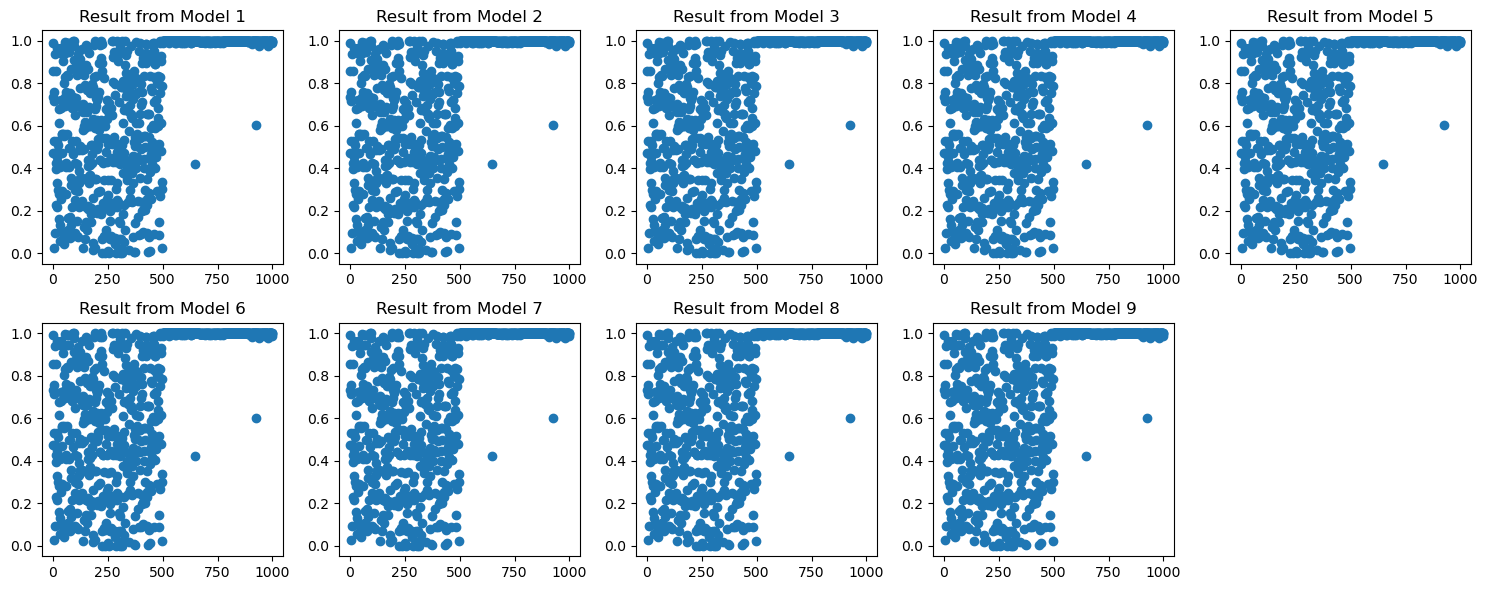

In [14]:
max_cols = 5 # for plotting purposes
max_rows = int(np.ceil(num_splits / 5)) # for plotting purposes
plt.figure(figsize=(15, max_rows * 3)) 
for i in range(num_splits):
    plt.subplot(max_rows, max_cols, i + 1) 
    plt.scatter(range(len(result_all[i])), result_all[i])
    plt.title(f"Result from Model {i+1}")
plt.tight_layout()
plt.show()

## Set threshold, evaluate performance of the ensemble

Confusion Matrix from model 1:
[[498   2]
 [ 39 461]]
Accuracy from model 1: 0.959
Precision from model 1: 0.9956803455723542
Recall from model 1: 0.922
Confusion Matrix from model 2:
[[498   2]
 [ 39 461]]
Accuracy from model 2: 0.959
Precision from model 2: 0.9956803455723542
Recall from model 2: 0.922
Confusion Matrix from model 3:
[[498   2]
 [ 39 461]]
Accuracy from model 3: 0.959
Precision from model 3: 0.9956803455723542
Recall from model 3: 0.922
Confusion Matrix from model 4:
[[498   2]
 [ 39 461]]
Accuracy from model 4: 0.959
Precision from model 4: 0.9956803455723542
Recall from model 4: 0.922
Confusion Matrix from model 5:
[[498   2]
 [ 39 461]]
Accuracy from model 5: 0.959
Precision from model 5: 0.9956803455723542
Recall from model 5: 0.922
Confusion Matrix from model 6:
[[498   2]
 [ 39 461]]
Accuracy from model 6: 0.959
Precision from model 6: 0.9956803455723542
Recall from model 6: 0.922
Confusion Matrix from model 7:
[[498   2]
 [ 39 461]]
Accuracy from model 7: 0.959

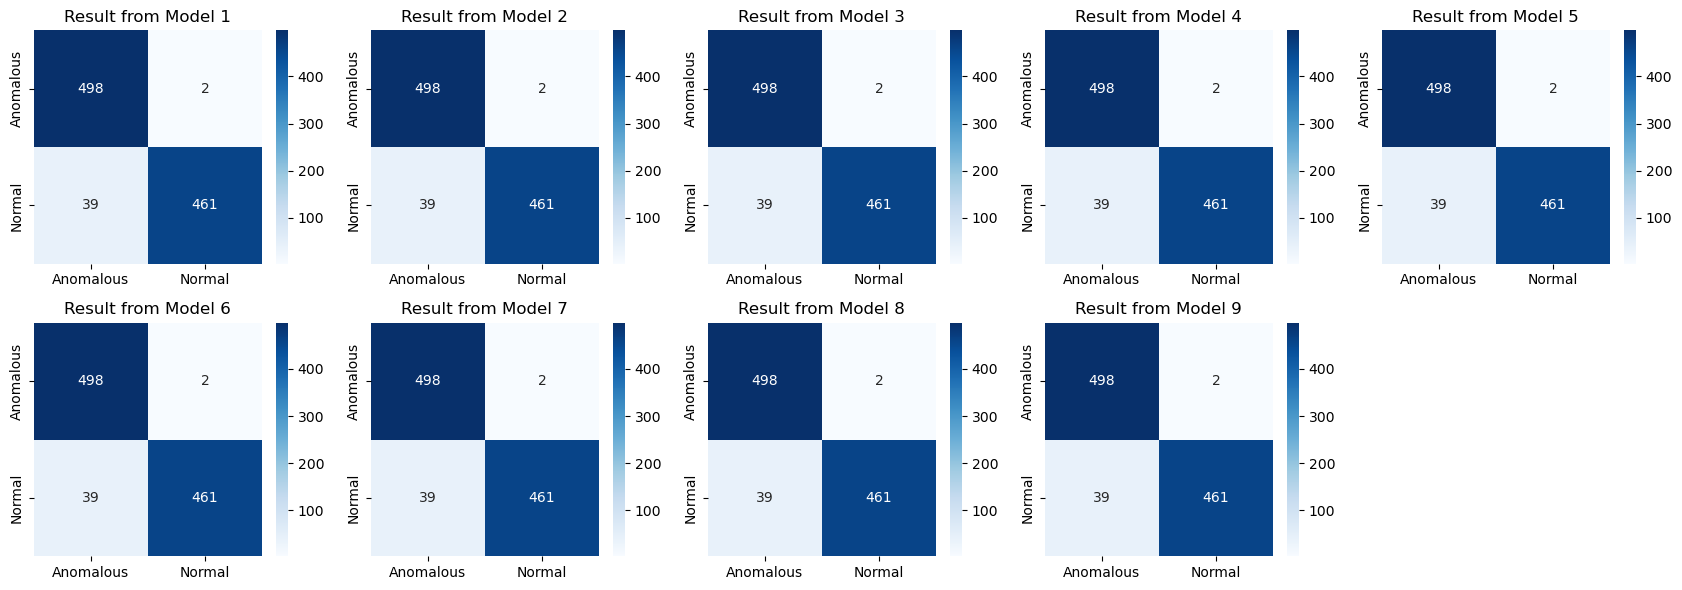

In [15]:
alpha = 0.05

selected_indices_all = []
predicted_labels_all = []
cm_all = []
accuracy_all = []
precision_all = []
recall_all = []

for i in range(num_splits):
    result_i = result_all[i]
    selected_indices_i = np.where(result_i > 1-alpha)
    selected_indices_all.append(selected_indices_i)
    selected_values_i = result_i[selected_indices_i]

    predicted_labels_i = np.ones_like(true_labels)
    predicted_labels_i[selected_indices_i] = 0
    predicted_labels_all.append(predicted_labels_i)

    cm_i = confusion_matrix(true_labels, predicted_labels_i)
    cm_all.append(cm_i)

    print(f"Confusion Matrix from model {i+1}:")
    print(cm_i)

    accuracy_i = accuracy_score(true_labels, predicted_labels_i)
    accuracy_all.append(accuracy_i)
    precision_i = precision_score(true_labels, predicted_labels_i)
    precision_all.append(precision_i)
    recall_i = recall_score(true_labels, predicted_labels_i)
    recall_all.append(recall_i)

    print(f"Accuracy from model {i+1}: {accuracy_i}")
    print(f"Precision from model {i+1}: {precision_i}")
    print(f"Recall from model {i+1}: {recall_i}")

plt.figure(figsize=(17, max_rows * 3)) 
for i in range(num_splits):
    plt.subplot(max_rows, max_cols, i + 1) 
    sns.heatmap(cm_all[i], annot=True, fmt="d", cmap="Blues", xticklabels=['Anomalous', 'Normal'], yticklabels=['Anomalous', 'Normal'])
    plt.title(f"Result from Model {i+1}")
plt.tight_layout()
plt.show()

## Merge results
The anomaly score of the ensemble is the sample average of the anomaly scores of the models.

Confusion for the ensemble:
[[498   2]
 [ 39 461]]
Accuracy for the ensemble: 0.959
Precision for the ensemble: 0.9956803455723542
Recall for the ensemble: 0.922


<Axes: >

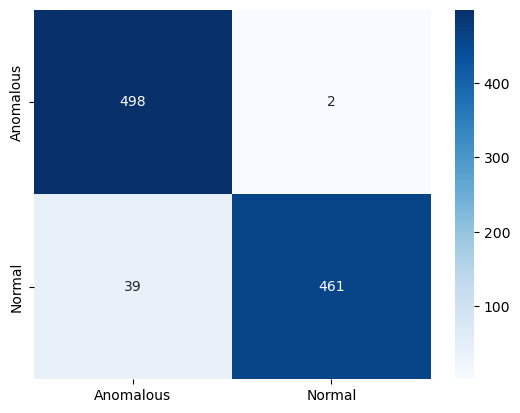

In [16]:
alpha = 0.05

result_merged = np.array([sum(x)/num_splits for x in zip(*result_all)])

selected_indices_merged = np.where(result_merged > 1-alpha)
selected_values_merged = result_i[selected_indices_merged]

predicted_labels_merged = np.ones_like(true_labels)
predicted_labels_merged[selected_indices_merged] = 0

cm_merged = confusion_matrix(true_labels, predicted_labels_merged)

print(f"Confusion for the ensemble:")
print(cm_merged)

accuracy_merged = accuracy_score(true_labels, predicted_labels_merged)
precision_merged = precision_score(true_labels, predicted_labels_merged)
recall_merged = recall_score(true_labels, predicted_labels_merged)

print(f"Accuracy for the ensemble: {accuracy_merged}")
print(f"Precision for the ensemble: {precision_merged}")
print(f"Recall for the ensemble: {recall_merged}")

sns.heatmap(cm_merged, annot=True, fmt="d", cmap="Blues", xticklabels=['Anomalous', 'Normal'], yticklabels=['Anomalous', 'Normal'])

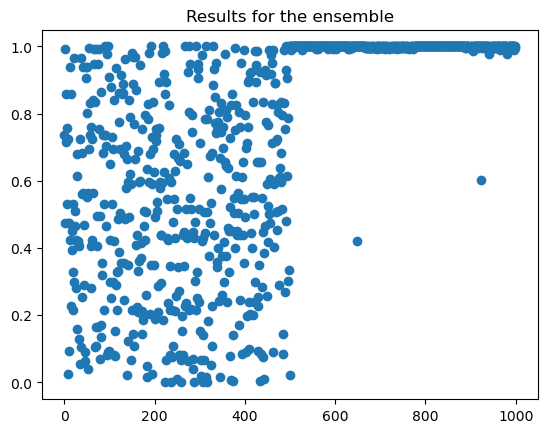

In [17]:
plt.scatter(range(len(result_merged)), result_merged)
plt.title(f"Results for the ensemble")
plt.show()